In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F

## Unsupservised Dataset

In [3]:
# Functions
def _create_mask(
    image_tensor: torch.Tensor, n_repeats: int = 8
) -> tuple[torch.Tensor, torch.Tensor]:
    """Create a mask and its inverse for the image.

    Start with random bit image and repeatedly blur with a filter of form [1/4, 1/2, 1/4] in both horizontal and vertical direction. Threshold the image to get a binary mask.

    Note: I played around with this and found that 8 repeats gives a mask that makes the most sense. I do wonder if it's not better to start with a positive masks that ensures larger regions of 1's than 0's, which is not always the case here.

    Args:
        image_tensor (torch.Tensor): image tensor (1x28x28)

    Returns:
        tuple[torch.Tensor, torch.Tensor]: mask tensor, inverse of mask tensor
    """
    # Create random bit image
    mask = torch.randint(0, 2, image_tensor.shape).float()

    # Blur the image
    for _ in range(n_repeats):
        mask = F.conv2d(
            mask,
            torch.tensor([0.25, 0.5, 0.25]).view(1, 1, 3, 1),
            padding=(0, 1),
        )
        mask = F.conv2d(
            mask,
            torch.tensor([0.25, 0.5, 0.25]).view(1, 1, 1, 3),
            padding=(1, 0),
        )

    mask = (mask > 0.5).float()  # threshold
    mask_inv = 1 - mask  # inverse

    return mask, mask_inv

def _load_mnist(root: str = "data"):
    """Load MNIST dataset.

    Returns:
        tuple[torch.utils.data.Dataset, torch.utils.data.Dataset]: train dataset, test dataset
    """
    print("Loading MNIST dataset...")
    # Transformations
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )

    # Load datasets
    train_dataset = MNIST(root=root, train=True, download=True, transform=transform)
    test_dataset = MNIST(root=root, train=False, download=True, transform=transform)

    return train_dataset, test_dataset

In [4]:
train_dataset, test_dataset = _load_mnist("../data")

Loading MNIST dataset...


Text(0.5, 1.0, 'Inverse Mask')

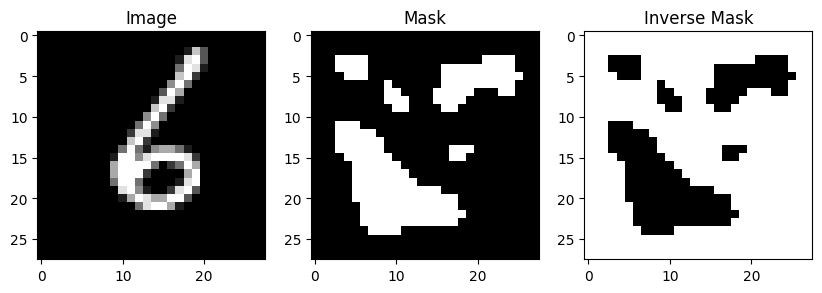

In [5]:
# Take a random image from the train dataset
image, _ = train_dataset[random.randint(0, len(train_dataset) - 1)]
mask, mask_inv = _create_mask(image)

# Plot the image and the masks
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(mask.squeeze(), cmap="gray")
ax[1].set_title("Mask")
ax[2].imshow(mask_inv.squeeze(), cmap="gray")
ax[2].set_title("Inverse Mask")

Text(0.5, 1.0, 'Image 2')

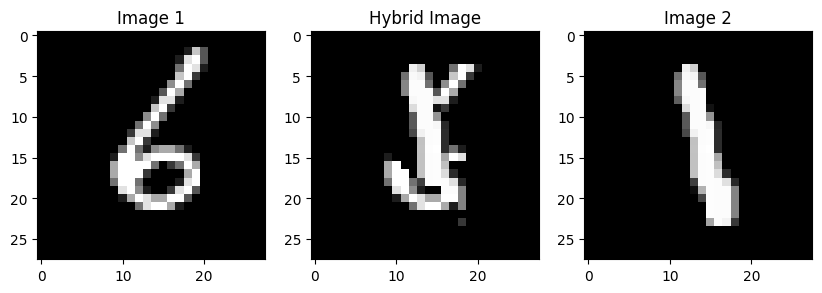

In [6]:
# Apply the mask to the image times the inverse mask applied to a different random image
image2, _ = train_dataset[random.randint(0, len(train_dataset) - 1)]
negative_image = image2 * mask_inv + image * mask

# Plot the image, negative image, and image2
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Image 1")
ax[1].imshow(negative_image.squeeze(), cmap="gray")
ax[1].set_title("Hybrid Image")
ax[2].imshow(image2.squeeze(), cmap="gray")
ax[2].set_title("Image 2")

## Supervised

In [7]:
def create_positive_sample(image: torch.Tensor, label: int):
    """Create a positive sample by taking an image and replacing the first 10 pixels by a one of N representation of the label"""
    modified_image = image.clone()
    modified_image[:, 0, :10] = image.min() # ensure no overlap with number
    modified_image[:,0,label] = image.max()
    return modified_image

# Create a positive sample
image, label = train_dataset[random.randint(0, len(train_dataset) - 1)]
positive_image = create_positive_sample(image, label)

Text(0.5, 1.0, 'Positive Image')

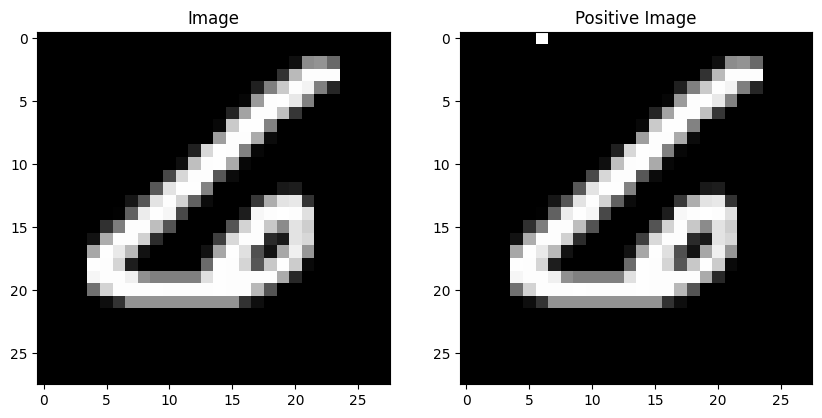

In [8]:
# Plot the positive image and the modified image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(positive_image.squeeze(), cmap="gray")
ax[1].set_title("Positive Image")

In [9]:
def create_negative_sample(image: torch.Tensor, label: int):
    """Create a negative sample by taking an image and replacing the first 10 pixels by a one of N representation of a different label"""
    choices = list(range(10))
    choices.remove(label)
    dif_label = random.choice(choices)

    modified_image = image.clone()
    modified_image[:, 0, :10] = image.min() # ensure no overlap with number
    modified_image[:,0,dif_label] = image.max()
    return modified_image

# Create a negative sample
image, label = train_dataset[random.randint(0, len(train_dataset) - 1)]
negative_image = create_negative_sample(image, label)

Text(0.5, 1.0, 'Negative Image')

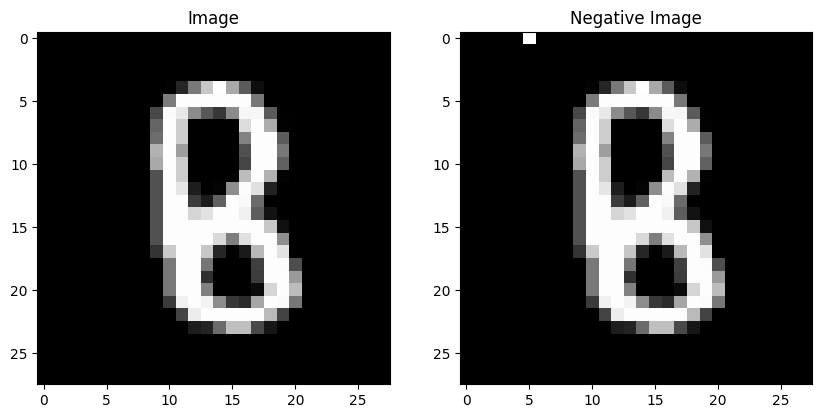

In [10]:
# Plot the negative image and the modified image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(negative_image.squeeze(), cmap="gray")
ax[1].set_title("Negative Image")